# Analyzing M2D features: How is the partial dimensional collapse in the pre-trained M2D representation?

Are some dimensions of M2D [4] feature vectors collapsed?

Here, we check it with the FSD50K [3] samples following the method in [1].

We also estimate the effective rank of the features using the method RankMe [2].

- [1] Li et al., "Understanding Collapse in Non-Contrastive Siamese Representation Learning," in ECCV, 2022, https://arxiv.org/abs/2209.15007, https://link.springer.com/chapter/10.1007/978-3-031-19821-2_28
- [2] Garrido, et al, "RankMe: Assessing the Downstream Performance of Pretrained Self-Supervised Representations by Their Rank," in ICML, 2023, https://proceedings.mlr.press/v202/garrido23a.html
- [3] Fonseca et al., “FSD50K: an Open Dataset of Human-Labeled Sound Events,” IEEE TASLP 2021, https://arxiv.org/abs/2010.00475, https://ieeexplore.ieee.org/document/9645159
- [4] Niizumi et al., "Masked Modeling Duo: Learning Representations by Encouraging Both Networks to Model the Input," in ICASSP, 2023, https://arxiv.org/abs/2210.14648, https://ieeexplore.ieee.org/document/10097236

In [1]:
from dlcliche.notebook import *
from dlcliche.torch_utils import *

Prepare a BYOL-A instance.

In [2]:
BASE = '/lab/m2d'
sys.path.append(BASE)

from m2d.runtime_audio import RuntimeM2D

device = torch.device('cuda')

# Prepare your batch of audios. This is a dummy  example of three 10s  waves.
batch_audio = 2 * torch.rand((3, 10 * 16000)) - 1.0 # input range = [-1., 1]
batch_audio = batch_audio.to(device)

# Create a model with pretrained weights.
runtime = RuntimeM2D(weight_file=BASE+'/m2d_vit_base-80x608p16x16-220930-mr7/checkpoint-300.pth')
runtime = runtime.to(device)
runtime.eval()

# We check raw features (768d) instead of the default M2D feature (3,840d) summarized in time frames.
runtime.cfg.flat_features = True

# Encode raw audio into features. `encode()` will do the followings automatically:
# 1. Convert the input `batch_audio` to log-mel spectrograms (LMS).
# 2. Normalize the batch LMS with mean and std calculated from the batch.
# 3. Encode the bach LMS to features.
frame_level = runtime.encode(batch_audio)

# This example ends up with frame-level 3840-d feature vectors for 63 time frames.
# The `frame_level` will have a size of torch.Size([3, 63, 3840]).
print(frame_level.shape)

 using 150 parameters, while dropped 250 out of 400 parameters from /lab/m2d/m2d_vit_base-80x608p16x16-220930-mr7/checkpoint-300.pth
<All keys matched successfully>
torch.Size([3, 315, 768])


In [3]:
import librosa

fsd50k_files = sorted(Path('/lab/byol-a/work/16k/fsd50k/FSD50K.dev_audio').glob('*.wav'))
random.shuffle(fsd50k_files)

# Calculate log-mel spectrogram statistics
N = 1000
lmss = None
for fpath in fsd50k_files[:N]:
    wav, sr = librosa.load(fpath, sr=None)
    assert sr == runtime.cfg.sample_rate, "Let's convert the audio sampling rate in advance, or do it here online."
    with torch.no_grad():
        lms = runtime.to_feature(torch.tensor(wav).to(device).unsqueeze(0))
        lmss = lms if lmss is None else torch.concat([lmss, lms], dim=-1)
lms_mean, lms_std = lmss.mean(), lmss.std()
lmss.shape, lms_mean, lms_std

(torch.Size([1, 1, 80, 709772]),
 tensor(-10.1609, device='cuda:0'),
 tensor(4.4269, device='cuda:0'))

In [4]:
N = 2000
features = []
for fpath in fsd50k_files[:N]:
    wav, sr = librosa.load(fpath, sr=None)
    assert sr == runtime.cfg.sample_rate, "Let's convert the audio sampling rate in advance, or do it here online."
    with torch.no_grad():
        lms = runtime.to_feature(torch.tensor(wav).to(device).unsqueeze(0))
        lms = (lms - lms_mean) / lms_std
        x, *_ = runtime.encode_lms(lms)
        features.append(x.cpu())
features = torch.vstack(features)
features.shape

torch.Size([455015, 768])

In [5]:
import analyze_repr

print(analyze_repr.get_cumulative_explained_variance_auc(features))

tensor(0.7558)


torch.Size([768]) torch.Size([]) torch.Size([768])


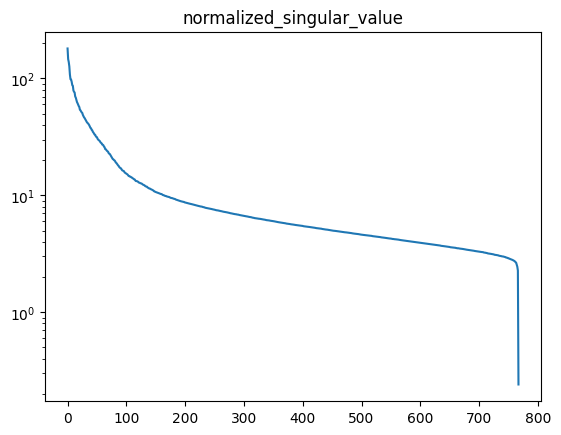

tensor(0.7558)


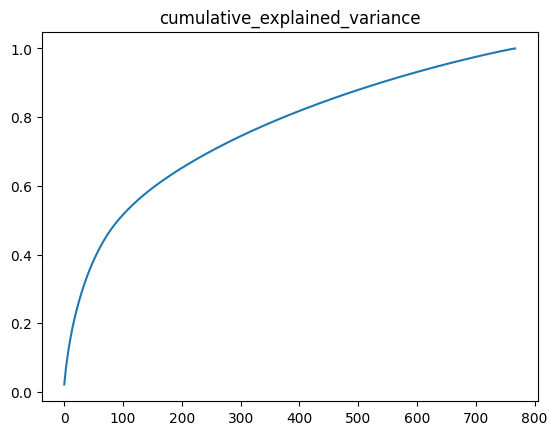

In [6]:
nsv = analyze_repr.normalized_singular_value(features)
auc, cev = analyze_repr.cumulative_explained_variance(nsv)
print(nsv.shape, auc.shape, cev.shape)

plt.plot(nsv.cpu().numpy())
plt.title('normalized_singular_value')
plt.yscale('log')
plt.show()

print(auc)
plt.plot(cev.numpy())
plt.title('cumulative_explained_variance')
plt.show()

### How many are the feature dimensions collapsed?

In [7]:
collapse_ratio = sum(nsv < 1e-4) / nsv.shape[0]
print(f'{collapse_ratio * 100:.4} % of the feature dimensions are just zero.')

0.0 % of the feature dimensions are just zero.


### Check the feature dimension collapse with the effective rank using RankMe

In [8]:
rank = analyze_repr.rank_me(features)
print(f'The effective rank is {rank:.4}, i.e., {rank / features.shape[-1] * 100:.4} % of the feature dimensions are effective.')

The effective rank is 389.7, i.e., 50.74 % of the feature dimensions are effective.


## Testing with more samples

Confirmed to be the same.

In [9]:
N = 10000
features = []
for fpath in fsd50k_files[:N]:
    wav, sr = librosa.load(fpath, sr=None)
    assert sr == runtime.cfg.sample_rate, "Let's convert the audio sampling rate in advance, or do it here online."
    with torch.no_grad():
        lms = runtime.to_feature(torch.tensor(wav).to(device).unsqueeze(0))
        lms = (lms - lms_mean) / lms_std
        x, *_ = runtime.encode_lms(lms)
        features.append(x.cpu())
features = torch.vstack(features)
features.shape

torch.Size([2223975, 768])

tensor(0.7533)
torch.Size([768]) torch.Size([]) torch.Size([768])


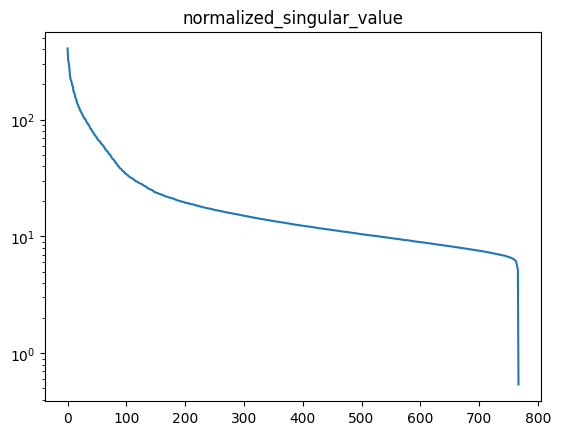

tensor(0.7533)


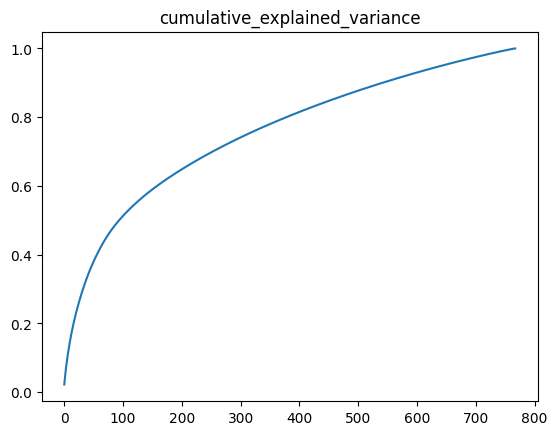

0.0 % of the feature dimensions are just zero.
The effective rank is 394.2, i.e., 51.33 % of the feature dimensions are effective.


In [10]:
print(analyze_repr.get_cumulative_explained_variance_auc(features))

nsv = analyze_repr.normalized_singular_value(features)
auc, cev = analyze_repr.cumulative_explained_variance(nsv)
print(nsv.shape, auc.shape, cev.shape)

plt.plot(nsv.cpu().numpy())
plt.title('normalized_singular_value')
plt.yscale('log')
plt.show()

print(auc)
plt.plot(cev.cpu().numpy())
plt.title('cumulative_explained_variance')
plt.show()

collapse_ratio = sum(nsv < 1e-4) / nsv.shape[0]
print(f'{collapse_ratio * 100:.4} % of the feature dimensions are just zero.')

rank = analyze_repr.rank_me(features)
print(f'The effective rank is {rank:.4}, i.e., {rank / features.shape[-1] * 100:.4} % of the feature dimensions are effective.')